# Applying ARCH/GARCH Models in Foreign Exchange (FX) Markets 

## Introduction

## 1. Importing Libraries
In this section, we'll import the required libraries for this notebook

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

## 2. Set up your API from Fred
In this section we are going to make our first API call.

In [104]:
import os

api_key = os.getenv('FRED_API_KEY', '060213f8f9bc0f09d86c251b43f3e1dc')
fred = Fred(api_key=api_key)

## 3. Fetch Data

In [105]:
# Retrieve EUR/USD Exchange Rate and assign a name
eur_usd = fred.get_series('DEXUSEU')
eur_usd.name = 'EUR/USD'

# Retrieve US Federal Reserve Interest Rate and assign a name
us_interest_rate = fred.get_series('FEDFUNDS')
us_interest_rate.name = 'US Interest Rate'

# Retrieve ECB Interest Rate
eu_interest_rate = pd.read_csv(r"D:\Projects\Data\ECB Data Portal_20240812162427(1).csv")

# Convert the 'DATE' column to a datetime format
eu_interest_rate['DATE'] = pd.to_datetime(eu_interest_rate['DATE'])

In [106]:
# Convert the 'DATE' column to a datetime format
eu_interest_rate['DATE'] = pd.to_datetime(eu_interest_rate['DATE'])

# Merge data by date
merged_data = pd.merge(eur_usd, us_interest_rate, left_index=True, right_index=True, how='inner')
merged_data = pd.merge(merged_data, eu_interest_rate.set_index('DATE'), left_index=True, right_index=True, how='inner')

# Rename the column for EU Interest Rate
merged_data.rename(columns={'Deposit facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.DFR.LEV)': 'EU Interest Rate'}, inplace=True)

# Drop any missing values
merged_data.dropna(inplace=True)

merged_data.head()

,EUR/USD,US Interest Rate,TIME PERIOD,EU Interest Rate,Marginal lending facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.MLFR.LEV),Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)
1999-02-01,1.1303,4.76,01 Feb 1999,2.0,4.5,3.0
1999-03-01,1.0891,4.81,01 Mar 1999,2.0,4.5,3.0
1999-04-01,1.0782,4.74,01 Apr 1999,2.0,4.5,3.0
1999-06-01,1.0449,4.76,01 Jun 1999,1.5,3.5,2.5
1999-07-01,1.0236,4.99,01 Jul 1999,1.5,3.5,2.5


                   EUR/USD  US Interest Rate  EU Interest Rate
EUR/USD           1.000000         -0.384550         -0.229081
US Interest Rate -0.384550          1.000000          0.771772
EU Interest Rate -0.229081          0.771772          1.000000


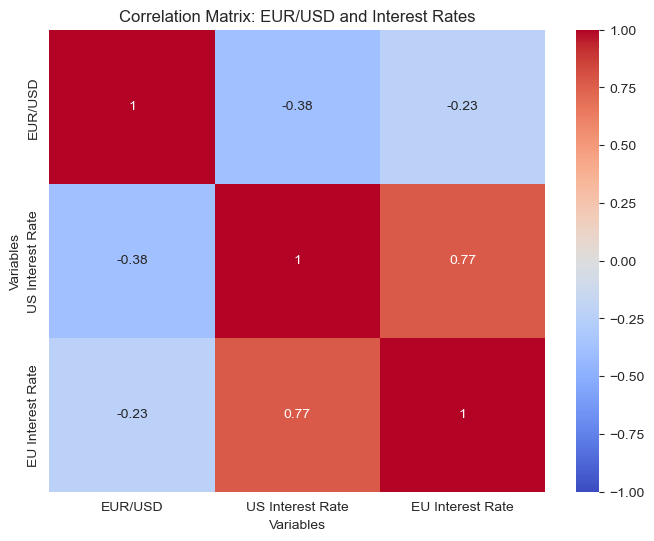

In [107]:
# Select only numeric columns for correlation
numeric_columns = merged_data[['EUR/USD', 'US Interest Rate', 'EU Interest Rate']]

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix: EUR/USD and Interest Rates')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()# Calculate the correlation matrix

In [108]:
import numpy as np

# Calculate log returns for the EUR/USD exchange rate
merged_data['EUR/USD Log Return'] = np.log(merged_data['EUR/USD'] / merged_data['EUR/USD'].shift(1))

# Drop NaN values resulting from the shift operation
merged_data.dropna(inplace=True)

merged_data['EUR/USD Log Return'].head()

1999-03-01   -0.037131
1999-04-01   -0.010059
1999-06-01   -0.031372
1999-07-01   -0.020595
1999-09-01    0.033244
Name: EUR/USD Log Return, dtype: float64

In [109]:
# Check stationarity using ADF test (you can implement this step)
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged_data['US Interest Rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Difference the interest rates to make them stationary if needed
merged_data['US Interest Rate Diff'] = merged_data['US Interest Rate'].diff()
merged_data['EU Interest Rate Diff'] = merged_data['EU Interest Rate'].diff()

# Drop NaN values resulting from the differencing operation
merged_data.dropna(inplace=True)

ADF Statistic: -3.2751844168404762
p-value: 0.01602483399605446


In [110]:
# Create a copy of the relevant columns for modeling to avoid the SettingWithCopyWarning
model_data = merged_data[['EUR/USD Log Return', 'US Interest Rate Diff', 'EU Interest Rate Diff']].copy()

# Drop any rows with NaN values
model_data.dropna(inplace=True)

# Display the first few rows of the prepared data
print(model_data.head())

            EUR/USD Log Return  US Interest Rate Diff  EU Interest Rate Diff
1999-04-01           -0.010059                  -0.07                    0.0
1999-06-01           -0.031372                   0.02                   -0.5
1999-07-01           -0.020595                   0.23                    0.0
1999-09-01            0.033244                   0.23                    0.0
1999-10-01            0.012770                  -0.02                    0.0


In [111]:
from arch import arch_model

# Rescale the log returns by multiplying by 10
model_data['EUR/USD Log Return Rescaled'] = model_data['EUR/USD Log Return'] * 10

# Define the GARCH model with the rescaled data
rescaled_model = arch_model(model_data['EUR/USD Log Return Rescaled'], vol='Garch', p=1, q=1, mean='Constant', x=model_data[['US Interest Rate Diff', 'EU Interest Rate Diff']])

# Fit the model
rescaled_model_fit = rescaled_model.fit()

# Print the summary of the rescaled model
print(rescaled_model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 438.1658136075057
Iteration:      2,   Func. Count:     15,   Neg. LLF: 808.2370774963579
Iteration:      3,   Func. Count:     24,   Neg. LLF: 293.1091740062273
Iteration:      4,   Func. Count:     31,   Neg. LLF: 71.57341286561962
Iteration:      5,   Func. Count:     37,   Neg. LLF: 64.45670201136684
Iteration:      6,   Func. Count:     42,   Neg. LLF: 64.45663446909435
Iteration:      7,   Func. Count:     47,   Neg. LLF: 64.45663086648668
Iteration:      8,   Func. Count:     51,   Neg. LLF: 64.45663086647488
Optimization terminated successfully    (Exit mode 0)
            Current function value: 64.45663086648668
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
                          Constant Mean - GARCH Model Results                          
Dep. Variable:     EUR/USD Log Return Rescaled   R-squared:                       0.000
Mean Model:                      Constant

In [112]:
# Example: EGARCH model
egarch_model = arch_model(model_data['EUR/USD Log Return Rescaled'], vol='EGarch', p=1, q=1, mean='Constant', x=model_data[['US Interest Rate Diff', 'EU Interest Rate Diff']])
egarch_model_fit = egarch_model.fit()

# Print the summary of the EGARCH model
print(egarch_model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2369.263289930188
Iteration:      2,   Func. Count:     14,   Neg. LLF: 149506.17108083976
Iteration:      3,   Func. Count:     23,   Neg. LLF: 50639173547.301636
Iteration:      4,   Func. Count:     32,   Neg. LLF: 63.77724091869932
Iteration:      5,   Func. Count:     37,   Neg. LLF: 66.43500179015926
Iteration:      6,   Func. Count:     44,   Neg. LLF: 63.79419958241836
Iteration:      7,   Func. Count:     50,   Neg. LLF: 63.76513841124694
Iteration:      8,   Func. Count:     55,   Neg. LLF: 63.7651346477354
Iteration:      9,   Func. Count:     59,   Neg. LLF: 63.76513474339994
Optimization terminated successfully    (Exit mode 0)
            Current function value: 63.7651346477354
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                          Constant Mean - EGARCH Model Results                         
Dep. Variable:     EUR/USD Log Return Rescaled   R-square

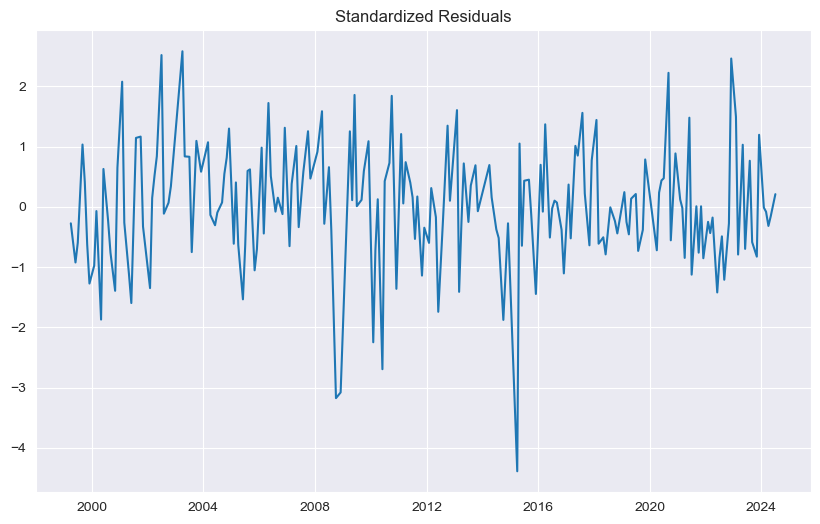

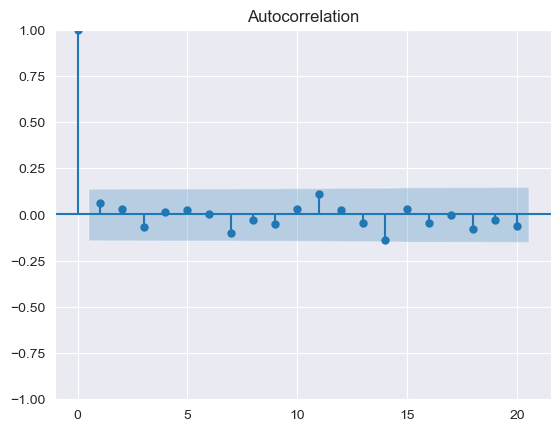

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Get the standardized residuals
standardized_residuals = egarch_model_fit.resid / egarch_model_fit.conditional_volatility

# Plot standardized residuals
plt.figure(figsize=(10, 6))
plt.plot(standardized_residuals)
plt.title('Standardized Residuals')
plt.show()

# Plot the ACF (Autocorrelation Function) of the standardized residuals
plot_acf(standardized_residuals, lags=20)
plt.show()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 57570815629.68614
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2815.03260241736
Iteration:      3,   Func. Count:     27,   Neg. LLF: 70.52129136270098
Iteration:      4,   Func. Count:     35,   Neg. LLF: 78.18051829278426
Iteration:      5,   Func. Count:     43,   Neg. LLF: 62.30121014072519
Iteration:      6,   Func. Count:     49,   Neg. LLF: 62.29092368657935
Iteration:      7,   Func. Count:     55,   Neg. LLF: 62.28990792308586
Iteration:      8,   Func. Count:     61,   Neg. LLF: 62.28975176018094
Iteration:      9,   Func. Count:     67,   Neg. LLF: 62.289701323156486
Iteration:     10,   Func. Count:     73,   Neg. LLF: 62.289695265262054
Iteration:     11,   Func. Count:     78,   Neg. LLF: 62.289695265196215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 62.289695265262054
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations:

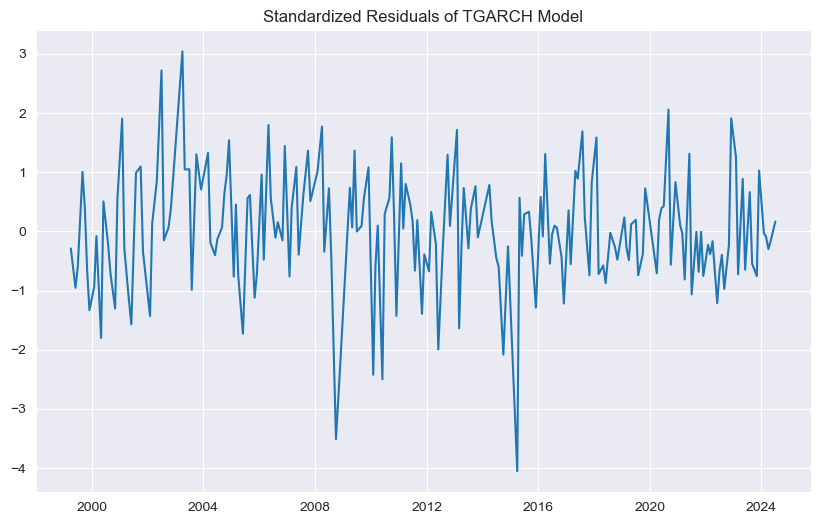

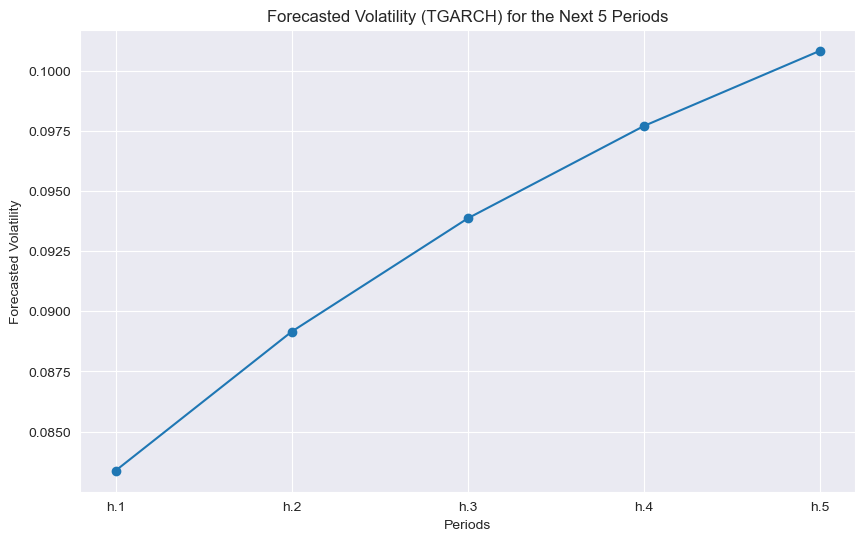

In [114]:
from arch import arch_model

# Fit a TGARCH model (also known as GJR-GARCH)
tgarch_model = arch_model(model_data['EUR/USD Log Return Rescaled'], vol='GARCH', p=1, o=1, q=1, mean='Constant', x=model_data[['US Interest Rate Diff', 'EU Interest Rate Diff']])

# Fit the model
tgarch_model_fit = tgarch_model.fit()

# Print the summary of the TGARCH model
print(tgarch_model_fit.summary())

# Plot the standardized residuals of the TGARCH model
standardized_residuals_tgarch = tgarch_model_fit.resid / tgarch_model_fit.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(standardized_residuals_tgarch)
plt.title('Standardized Residuals of TGARCH Model')
plt.show()

# Forecast with the TGARCH model
forecast_tgarch = tgarch_model_fit.forecast(horizon=5, reindex=False)
forecasted_volatility_tgarch = forecast_tgarch.variance.iloc[-1, :]

plt.figure(figsize=(10, 6))
plt.plot(forecasted_volatility_tgarch, marker='o')
plt.title('Forecasted Volatility (TGARCH) for the Next 5 Periods')
plt.xlabel('Periods')
plt.ylabel('Forecasted Volatility')
plt.show()
